# Accuracy of diagnostic tests registered by ANVISA for COVID-19

Research: 

Foi conduzida uma pesquisa documental utilizando os dados fornecidos pelos fabricantes no ato do registro na Anvisa. Foram analisados os testes di agnósticos registrados na Anvisa até o dia 23 de junho de 2020, período da coleta de dados, utilizando como ferramenta [esse link](https://consultas.anvisa.gov.br/#/saude/q/?nomeTecnico=coronav%C3%ADrus). 

Os dados informados no ato do registro na Anvisa foram extraídos da página da internet da Agência, da Gerência Geral de Tecnologia de Produtos para Saúde (GGTPS) de diagnóstico in vitro. Para apresentação dos dados, utilizou-se tabela padrão produzida pelos autores, sendo coletados os seguintes dados: i) empresa/importadora; ii) fabricante/país; iii) amostra; iv) se foi considerado como teste rápido v) número de registro na Anvisa; vi) dados
de sensibilidade/especificidade apresentados pelo fabricante. Os dados informados pela indústria na ocasião do registro junto à Anvisa foram utilizados para elaborar gráficos de especificidade e sensibilidade dos testes diagnósticos. 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import sys
sys.path.append('../scripts')

from parameter_estimation import BivariateBeta

Os dados fornecidos pelos fabricantes foram plotados nas figuras apresentadas para ilustrar sensibilidade e especificidade IgG e/ou IgM dos testes: 

a) imunocromatográfico com amostra de sangue (sangue total, sangue total venoso, sangue total via punção digital ou sangue seco), soro ou plasma humano; 

b) imunocromatográfico com secreção swab nasofaríngeo e swab orofaríngeo; 

c) imunoensaio com amostra de sangue (sangue total, sangue total venoso, sangue total via punção digital ou sangue seco), soro ou plasma humano; 

d) imunoinsaio com amostra secreção swab nasofaríngeo e swab orofaríngeo; 

e) detecção quali ou semiqualitativa com amostra de sangue

In [2]:
folder = '../data/covid_tests_data/'
filter_func = lambda i: lambda x: float(re.findall('[0-9].[0-9][0-9]', x.replace(',', '.'))[i])

Getting the data

In [7]:
tables = [pd.read_csv(folder+'raw/table_a.csv'),
          pd.read_csv(folder+'raw/table_b.csv'),
          pd.read_csv(folder+'raw/table_c.csv'),
          pd.read_csv(folder+'raw/table_d.csv'),
          pd.read_csv(folder+'raw/table_e.csv'),
          pd.read_csv(folder+'raw/table_pcr_a.csv'),
          pd.read_csv(folder+'raw/table_pcr_b.csv'),
          pd.read_csv(folder+'raw/table_pcr_c.csv'),
         ]

letters = ['a', 'b', 'c', 'd', 'e', 'a_pcr', 'b_pcr', 'c_pcr']
for i in range(8):

    tables[i]['sensitivity']          = tables[i]['Sensitivity [95% CI]'].apply(filter_func(0))
    tables[i]['sensitivity_ci_lower'] = tables[i]['Sensitivity [95% CI]'].apply(filter_func(1))
    tables[i]['sensitivity_ci_upper'] = tables[i]['Sensitivity [95% CI]'].apply(filter_func(2))
    tables[i]['specificity']          = tables[i]['Specificity [95% CI]'].apply(filter_func(0))
    tables[i]['specificity_ci_lower'] = tables[i]['Specificity [95% CI]'].apply(filter_func(1))
    tables[i]['specificity_ci_upper'] = tables[i]['Specificity [95% CI]'].apply(filter_func(2))
    tables[i]['type']                 = letters[i]
    
    del tables[i]['Sensitivity [95% CI]']
    del tables[i]['Specificity [95% CI]']
    
df = pd.concat(tables)

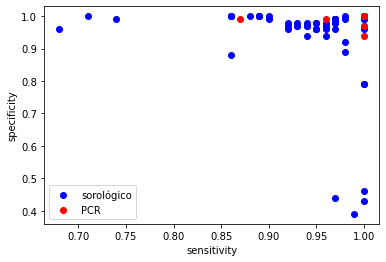

In [204]:
plt.scatter(df[~df.type.str.contains('pcr')].sensitivity, df[~df.type.str.contains('pcr')].specificity,
            color='blue', label='sorológico')
plt.scatter(df[df.type.str.contains('pcr')].sensitivity, df[df.type.str.contains('pcr')].specificity, 
            color='red', label='PCR')
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.legend(loc='lower left')
plt.show()

In [190]:
df.describe()

,Study,TP,FP,FN,TN,sensitivity,sensitivity_ci_lower,sensitivity_ci_upper,specificity,specificity_ci_lower,specificity_ci_upper
count,7.100000e+01,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,5.591396e+10,115.394366,13.971831,7.183099,191.676056,0.946901,0.835070,0.976479,0.942958,0.881127,0.962676
std,3.390722e+10,97.261427,45.681810,11.856656,212.390192,0.065500,0.174076,0.037037,0.132432,0.154064,0.113187
min,1.000901e+10,2.000000,0.000000,0.000000,5.000000,0.680000,0.160000,0.820000,0.390000,0.320000,0.440000
25%,1.034136e+10,49.000000,0.500000,0.000000,60.000000,0.930000,0.820000,0.970000,0.960000,0.890000,0.990000
50%,8.025802e+10,92.000000,2.000000,3.000000,124.000000,0.970000,0.890000,0.990000,0.980000,0.930000,1.000000
75%,8.086715e+10,169.000000,9.000000,7.500000,241.000000,1.000000,0.925000,1.000000,1.000000,0.960000,1.000000
max,8.198451e+10,422.000000,297.000000,49.000000,1364.000000,1.000000,0.980000,1.000000,1.000000,0.990000,1.000000


In [64]:
distribution = BivariateBeta()

x = df.specificity
y = df.sensitivity

m1 = np.mean(x)
m2 = np.mean(y)
v1 = np.var(x, ddof=1)
v2 = np.var(y, ddof=1)
rho = np.corrcoef(x, y)[0,1]

moments = [m1, m2, v1, v2, rho]

In [60]:
distribution.method_moments_estimator_1(x, y)

array([1.82542555, 0.12359079, 0.13174202, 0.        ])

In [61]:
distribution.method_moments_estimator_2(x, y)

array([       0.        ,        0.        ,        0.        ,
       33385287.08964973])

In [65]:
distribution.method_moments_estimator_3(x, y, alpha0=(1,1))

array([3.27312502e+00, 1.95309929e-01, 2.09815707e-01, 5.98999003e-17])

In [63]:
distribution.method_moments_estimator_4(x, y, alpha0=(1,1,1,1))

array([5.7846352 , 0.72017582, 0.74697218, 0.        ])

In [35]:
d = BivariateBeta(alpha_hat)

In [36]:
d.moments()

/home/lucasmoschen/Documents/GitHub/bivariate-beta/notebooks/../scripts/parameter_estimation.py:192: RuntimeWarning: divide by zero encountered in log
  den = np.log(alpha[0] + alpha[1]) + np.log(alpha[2] + alpha[3])
/home/lucasmoschen/Documents/GitHub/bivariate-beta/notebooks/../scripts/parameter_estimation.py:193: RuntimeWarning: divide by zero encountered in log
  den += np.log(alpha[0] + alpha[2]) + np.log(alpha[1] + alpha[3])
/home/lucasmoschen/Documents/GitHub/bivariate-beta/notebooks/../scripts/parameter_estimation.py:195: RuntimeWarning: invalid value encountered in double_scalars
  Cor_XY = (alpha[0]*alpha[3] - alpha[1]*alpha[2])*den


array([ 0.,  0.,  0.,  0., nan])

In [85]:
a = -distribution._system_three_solution(m1, m2, rho)

In [86]:
a

array([131.89148245,   8.92973866,   9.51868477,  -1.        ])

In [87]:
(a[0] + a[1])/a.sum() - m1

-1.1102230246251565e-16

In [88]:
(a[0] + a[2])/a.sum() - m2

-2.220446049250313e-16

In [82]:
(a[0]*a[3] - a[1]*a[2])/(np.sqrt((a[0]+a[1])*(a[0]+a[2])*(a[1]+a[3])*(a[2]+a[3])))

0.454897394582171

In [70]:
a

array([131.89148245,   8.92973866,   9.51868477,  -1.        ])

In [94]:
distribution._system_three_solution(0.001, 0.999, 0.99)

array([ 1.00000000e+00, -4.96984422e-01,  5.01512563e+02,  1.00000000e+00])

In [118]:
expr = lambda m1, m2: (1 - m1)*(1-m2) - 0.5*np.sqrt(m1*m2*(1-m1)*(1-m2))

In [186]:
rho = -0.99
m1, m2 = np.meshgrid(np.linspace(1e-8,1, 100, endpoint=False), np.linspace(1e-8,1, 100, endpoint=False))
z = distribution._system_three_solution(m1, m2, rho)
z = (z[0]<0)*(z[1]>0)*(z[2]>0)# + (z[0]<0)*(z[1]>0)*(z[2]<0)

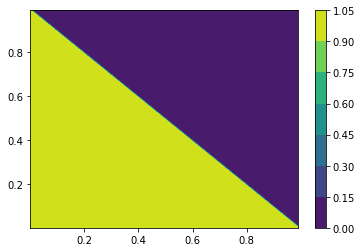

In [187]:
CS = plt.contourf(m1, m2, z)
plt.colorbar(CS)